## Google Colab setup (don't run locally)

In [1]:
from google.colab import drive
import os
import shutil

# Mount drive to colab
drive.mount('/content/drive', force_remount=True)

# setting up paths
path_to_project_files = '/content/drive/MyDrive/GaTech/2025 1Spring/DL/DeepLearning'
existing = os.path.join(path_to_project_files, 'kaggle.json')
path_to_colab_utils = '/root/.kaggle'
target = os.path.join(path_to_colab_utils, 'kaggle.json')

# move the key to the colab root
os.makedirs(path_to_colab_utils, exist_ok=True)
shutil.copy(existing, target)
os.chmod(target, 600)

# download the data into /content (which is temporary)
!kaggle datasets download -d xhlulu/leafsnap-dataset -p /content --unzip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/xhlulu/leafsnap-dataset
License(s): copyright-authors


In [2]:
import sys

# Edit this path to where you've uploaded the repo files, so the imports work.
sys.path.append('/content/drive/MyDrive/GaTech/2025 1Spring/DL/DeepLearning')

## Library Imports

In [1]:
from autoencoder import *
from dataloader import *

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os
from sklearn.metrics import f1_score

In [2]:
import matplotlib.pyplot as plt

def showTensorInNotebook(tensor):
    """
    This takes a (3[RGB], H, W) tensor in R[0.0, 1.0] and displays it with matplotlib.
    """
    image = tensor.detach().cpu().numpy().transpose(1,2,0) # move the channel axis to the end, because PIL and matplotlib hate each other
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Building the data loader

These are transforms that allow us to ingest the image tensors with some extra confusion at training time. `processor` makes the data loader spit out tensors, and `noiser` adds Gaussian noise.

NOTE: If you do not resize the images, the DataLoader will get upset, since the LeafSnap dataset does not have uniform size.

In [7]:
# This just processes the images.
H, W = 400, 400
outerH, outerW = 600, 600

processor = v2.Compose([
    v2.Resize((H, W)),
    #v2.Resize((outerH, outerW)),
    #v2.CenterCrop((H, W)), # since the lab images have meta information around the edges, crop out the center
    lambda x: x / 255.0, # convert Z[0, 255] to R[0.0, 1.0]
])
BATCH_SIZE = 32

# This adds the noise for training.
NOISE_RATIO = 0.1
noiser = v2.Compose([
    lambda x: torch.clip(x + NOISE_RATIO*torch.randn_like(x), 0.0, 1.0) # add the noise
])

This creates the DataLoader that you can use in training.

When iterating, you'll get a batch of `(BATCH_SIZE, {3 or 4 (if use_segmented)}, H, W)`.

In [8]:
root_directory = os.path.join(os.getcwd(), 'leafsnap-dataset')
train_images = os.path.join(os.getcwd(), "train.txt")
dataset = LeafsnapDataset(train_images, root_directory, use_segmented=False, source="field", transform=processor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Then, we need the DataLoader for testing. Same exact format.

In [9]:
test_images = os.path.join(os.getcwd(), "test.txt")
test_dataset = LeafsnapDataset(test_images, root_directory, use_segmented=False, source="field", transform=processor)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Building the model (CAE)

All hyperparameters are hard-coded in this model. A 3x400x400 image is bound to a dense encoding of 5000 features, using only convolution.

In [ ]:
model = ConvolutionalAutoencoder((BATCH_SIZE, 3, 400, 400), noiser, device=device)

# train_AE_model(model, dataloader, 20, 1e-4, device=device) # model already trained
model.load_state_dict(torch.load('CAE5k_model.pth'))

<All keys matched successfully>

Now, a test run of the reconstruction

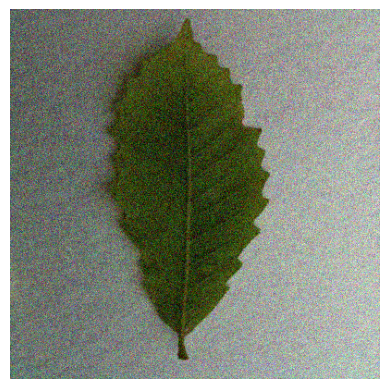

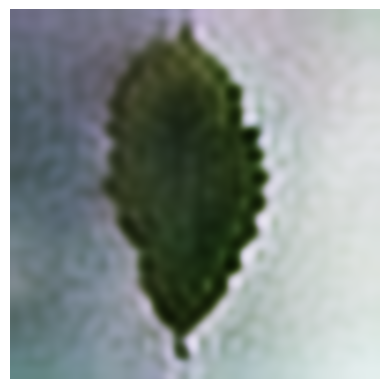

In [12]:
sample_train_image = noiser(dataset.__getitem__(400)[0].unsqueeze(0)).to(device)
showTensorInNotebook(sample_train_image.squeeze(0))
reconstruction = model.forward(sample_train_image)
showTensorInNotebook(reconstruction.squeeze(0))

In [14]:
torch.save(model.state_dict(), "CAE5k_model.pth")

## Building the classifier

In [ ]:
trained_autoencoder = ConvolutionalAutoencoder((BATCH_SIZE, 3, 400, 400), noiser, device=device)
trained_autoencoder.load_state_dict(torch.load('CAE5k_model.pth'))
trained_autoencoder.eval()

classifier = AEClassifier(trained_autoencoder.encoder, [5000, 500, 185], device=device)
for param in classifier.encoder.parameters():
    param.requires_grad = False

# train_classifier_head(classifier, dataloader, 10, 1e-3, device=device)
classifier.load_state_dict(torch.load('CAE5k_classifier.pth'))

<All keys matched successfully>

In [22]:
correct_top1 = 0
correct_top5 = 0
total = 0
all_preds = []
all_labels = []

classifier.to(device)
with torch.no_grad(): # No gradients needed for evaluation
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classifier(inputs)

        # Top-1 Accuracy
        _, predicted = torch.max(outputs, 1)
        correct_top1 += (predicted == labels).sum().item()

        # Top-5 Accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices
        correct_top5 += torch.sum(top5_preds.eq(labels.view(-1, 1))).item()

        total += labels.size(0)

        # For Macro-F1
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
top1_accuracy = 100 * correct_top1 / total
top5_accuracy = 100 * correct_top5 / total
macro_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")
print(f"Macro F1 Score: {macro_f1:.4f}")


Top-1 Accuracy: 1.44%
Top-5 Accuracy: 2.88%
Macro F1 Score: 0.0004


Well, it looks like the embedding really isn't storing much rich data. My instinct tells me that from the way I've designed this network, the bottleneck is just a really scaled down version of the image, and the decoder is just a good upscaler. Which means that this accuracy is just a normal classifier on some 8-channel 25px by 25px version of the image, which is understandably bad.

This is supported by the fact that this architecture is inspired by that of the denoising autoencoder (DAE), which adds in skip connections to increase high-res fidelity during decoding. The key there is that their downstream task is actually denoising and infilling, which it seems to be decent at, not extracting an encoding.

I'd like to attempt some versions of the variational autoencoder technique, and the ViT Masked Autoencoder.

In [17]:
torch.save(classifier.state_dict(), "CAE_classifier.pth")